#### Se usará la base de datos datos_credit_balanced_sin_correlación.csv

In [1]:
import pandas as pd

#### Para aumentar la velocidad de lectura del banco de datos, se guardará el csv en formato pkl que es considerablemente más rápido. De ahora en adelante se importará desde ese tipo de archivo

In [3]:
#original_data = pd.read_csv("./data/datos_credit_balanced_sin_correlacion.csv")
#pickeled_data = pd.to_pickle(original_data, "./pickled/datos_credit_balanced_sin_correlacion.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './data/datos_credit_balanced_sin_correlacion.csv'

In [4]:
from rich.console import Console
from rich import print
console = Console()

#### Clasificador K-NN

In [5]:
preprocessed_data = pd.read_pickle("./pickled/datos_credit_balanced_sin_correlacion_horas.pkl")
normalized_data = pd.read_pickle("./pickled/datos_credit_balanced_sin_correlacion_normalizado_horas.pkl")

#### Definimos los atributos y la clase objetivo para separar los datos en entrenamiento y prueba

In [6]:
FEATURES_PRE = preprocessed_data.drop('Class', axis=1)
TARGET_PRE = preprocessed_data['Class']
FEATURES_PRE = pd.get_dummies(FEATURES_PRE)

FEATURES_NORM = normalized_data.drop('Class', axis=1)
TARGET_NORM = normalized_data['Class']

In [7]:
from sklearn.model_selection import train_test_split

FEATURES_TRAIN_PRE, FEATURES_TEST_PRE, TARGET_TRAIN_PRE, TARGET_TEST_PRE = train_test_split(FEATURES_PRE, TARGET_PRE, test_size=0.3, random_state=42)
FEATURES_TRAIN_NORM, FEATURES_TEST_NORM, TARGET_TRAIN_NORM, TARGET_TEST_NORM = train_test_split(FEATURES_NORM, TARGET_NORM, test_size=0.3, random_state=42)

#### Sacamos la k óptima

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#### Esto tarda una cantidad considerable de tiempo (a mí me tardo 25 minutos para 1). Si no necesitas que use el 100% de la CPU, quita el argumento 'n_jobs' o ponlo a 1 ó 2, sin embargo esto hará que tarde más.

In [11]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(FEATURES_TRAIN_PRE,TARGET_TRAIN_PRE)
    pred_i = knn.predict(FEATURES_TEST_PRE)
    error_rate.append(np.mean(pred_i != TARGET_TEST_PRE))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)))

In [8]:
acc = []
from sklearn import metrics
for i in range(1, 5):
    neigh = KNeighborsClassifier(n_neighbors=i, weights='distance').fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
    yhat = neigh.predict(FEATURES_TEST_PRE)
    acc.append(cross_val_score(neigh, FEATURES_PRE, TARGET_PRE, cv=10, scoring='accuracy').mean())

Maximum accuracy:- 0.9819531153825862 at K = 1

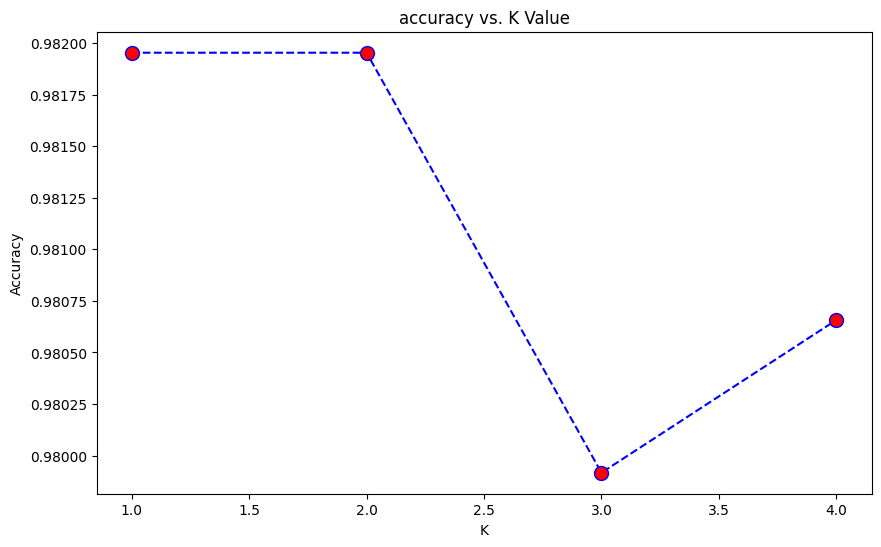

In [9]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-", max(acc),"at K =", acc.index(max(acc)) + 1)

#### Clasificador Naive Bayes

Clasificador Gaussiano, averiguamos el mejor modelo

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

gnb = GaussianNB()
param_grid = {'var_smoothing': [0.001, 0.01, 0.1, 1.0, 10.0]}
grid = GridSearchCV(gnb, param_grid, cv=5)
grid.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
best_gnb = grid.best_estimator_

print(best_gnb.var_smoothing)

0.01

In [18]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.metrics import confusion_matrix

y_pred = best_gnb.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE).predict(FEATURES_TEST_PRE)
print("Filas totales: %d \nFilas no clasificadas correctamente: %d" % (FEATURES_TEST_PRE.shape[0], (TARGET_TEST_PRE != y_pred).sum()))

conf_matrix = confusion_matrix(TARGET_TEST_PRE, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

Filas totales: 170589 
Filas no clasificadas correctamente: 27272

Matriz de confusión:

[[85052    97]
 [27175 58265]]

In [17]:
from sklearn.ensemble import BaggingClassifier

gnb = GaussianNB()
bagging_gnb = BaggingClassifier(base_estimator=gnb, n_estimators=20, random_state=42)
bagging_gnb.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
y_pred = bagging_gnb.predict(FEATURES_TEST_PRE)

print("Filas totales: %d \nFilas no clasificadas correctamente: %d" % (FEATURES_TEST_PRE.shape[0], (TARGET_TEST_PRE != y_pred).sum()))

conf_matrix = confusion_matrix(TARGET_TEST_PRE, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

c:\Users\12sga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Filas totales: 170589 
Filas no clasificadas correctamente: 16101

Matriz de confusión:

[[82855  2294]
 [13807 71633]]